In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torchvision
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

random_seed = 1
torch.manual_seed(random_seed)

In [2]:
#calling the dataloaders (iterators) to get the data.

def get_labeled_samples(X, y, n_samples):
    """Returns the labeled samples based on the number of samples defined by the arguments.

    Parameters
    ----------
    X : array_like, shape (n_samples, width, height, channels)
        correspond to the images of the dataset.
    y : array_like, shape (n_samples, )
        correspond to the labels for the images.

    Returns
    ----------
    X_sup : array_like, shape (n_samples, width, height, channels)
           correspond to the images that will be used as the supervised set.
    y_sup : array_like, shape (n_samples, )
            correspond to the labels for the images that will be used as the supervised set.
    n_samples (int): Nuber of samples per class to be labeled.
    """

    np.random.seed(0)

    classes = np.unique(y)
    indxs = [np.where(y == class_) for class_ in classes]

    ix = []
    for indx in indxs:
        ix.extend(np.random.choice(indx[0], n_samples, replace = False))

    np.random.shuffle(ix)
    X_sup = X[ix]
    y_sup = y[ix]

    return X_sup, y_sup, ix

class DigitDataset(data.Dataset):
    """This class is needed to process the batches for the dataloader."""
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.transform = transforms.Compose([transforms.Resize(32),
                                             transforms.ToTensor()])

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x = Image.fromarray(x)
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

def get_mnist(data_dir='./data/', batch_size=32):
    train = torchvision.datasets.MNIST(root=data_dir, train=True, download=True)
    test = torchvision.datasets.MNIST(root=data_dir, train=False, download=True)

    x_train = train.data.numpy()
    y_train = train.targets
    
    x_test = test.data.numpy()
    y_test = test.targets
    
    ## We need to repeat and concatenate the black-and-white images in order to match the 
    ## 3-channel RGB images dimension.
    
    x_train = np.repeat(x_train.reshape(-1, 28, 28, 1), 3, 3)
    x_test = np.repeat(x_test.reshape(-1, 28, 28, 1), 3, 3)
        
    x_val, y_val, ixs = get_labeled_samples(x_train, y_train, 1000)
    dataloader_val = DataLoader(DigitDataset(x_val, y_val), batch_size=batch_size, 
                                shuffle=False)

    x_train, y_train = np.delete(x_train, ixs, axis=0), np.delete(y_train, ixs, axis=0)
    dataloader_train = DataLoader(DigitDataset(x_train, y_train), batch_size=batch_size, 
                                shuffle=True, drop_last=True)

    dataloader_test = DataLoader(DigitDataset(x_test, y_test), batch_size=batch_size*2, 
                                shuffle=False)
    return dataloader_train, dataloader_val, dataloader_test

In [3]:
train_loader, val_loader, test_loader = get_mnist()
images, labels = iter(train_loader).next()

<Figure size 432x288 with 0 Axes>

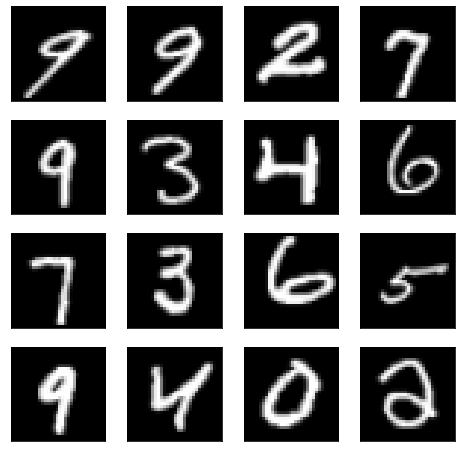

In [4]:
# Plotting some images

N_plots = 4

plt.clf()
fig, axes = plt.subplots(N_plots, N_plots, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(N_plots*N_plots):
    axes.flat[i].imshow(images[i][0], interpolation = "nearest", cmap='gray')

plt.show()

### Neural Network Architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, -1)

In [6]:
# Some Utilities :D
        
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class EarlyStopping:
    """Early stopping as the convergence criterion.
        Args:
            args (string): hyperparameters for the training.
            patience (int): the model will stop if it not do improve in a patience number of epochs.
        Returns:
            stop (bool): if the model must stop.
            if_best (bool): if the model performance is better than the previous models.
    """
    def __init__(self, patience=10):
        self.best_metric = 0.0
        self.counter = 0
        self.patience = patience

    def count(self, model, metric):
        is_best = bool(metric > self.best_metric)
        self.best_metric = max(metric, self.best_metric)
        if is_best:
            self.counter = 0
            torch.save(model.state_dict(), './trained_parameters_mnist.pth')
        else:
            self.counter += 1
        if self.counter > self.patience:
            stop = True
        else:
            stop = False
        return stop

In [7]:
from sklearn.metrics import accuracy_score


def evaluate(model, dataloader):
    """Evalute the unsupervised model."""
    model.eval()
    loss_metric = AverageMeter()
    acc_metric = AverageMeter()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.float()
            y = y.long()

            out = model(x)

            loss = F.cross_entropy(out, y)
            y_pred = np.argmax(out.detach().numpy(), axis=1)
            
            loss_metric.update(loss.item(), x.size(0))
            acc_metric.update(accuracy_score(y, y_pred), x.size(0))

    print('Test loss: {:.2f}, Accuracy: {:.2f}'.format(loss_metric.avg, acc_metric.avg))
    return loss_metric.avg, acc_metric.avg



def train(n_epochs, dataloader_train, dataloader_val):
    
    es = EarlyStopping()
    cumulated_loss, cumulated_acc = [], []
    cumulated_loss_val, cumulated_acc_val = [], []
    
    for epoch in range(n_epochs):
        loss_metric = AverageMeter()
        acc_metric = AverageMeter()
        print('Epoch: {}/{}'.format(epoch, n_epochs))
        for x, y in dataloader_train:
            model.train()
            x = x.float()
            y = y.long()
            
            out = model(x)

            loss = F.cross_entropy(out, y)
            #Computing gradients
            loss.backward()
            optimizer.step()
            
            y_pred = np.argmax(out.detach().numpy(), axis=1)
            
            loss_metric.update(loss.item(), x.size(0))
            acc_metric.update(accuracy_score(y, y_pred), x.size(0))
            #Zero grading for next iteration.
            optimizer.zero_grad()

        print('Training loss: {:.2f}, Accuracy: {:.2f}'.format(
                                                    loss_metric.avg, acc_metric.avg))
        cumulated_loss.append(loss_metric.avg)
        cumulated_acc.append(acc_metric.avg)
        
        loss_val, acc_val = evaluate(model, dataloader_val)
        stop = es.count(model, acc_val)
        cumulated_loss_val.append(loss_val)
        cumulated_acc_val.append(acc_val)
        
    return (cumulated_loss, cumulated_loss_val), (cumulated_acc, cumulated_acc_val)

In [8]:
#Hyperparameters

learning_rate = 0.0001
n_epochs = 20

model = Neural_Network()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
loss, acc = train(n_epochs, train_loader, val_loader)

Epoch: 0/20
Training loss: 1.89, Accuracy: 0.60
Test loss: 1.62, Accuracy: 0.86
Epoch: 1/20
Training loss: 1.68, Accuracy: 0.80
Test loss: 1.56, Accuracy: 0.91
Epoch: 2/20
Training loss: 1.63, Accuracy: 0.85
Test loss: 1.54, Accuracy: 0.93
Epoch: 3/20
Training loss: 1.60, Accuracy: 0.87
Test loss: 1.52, Accuracy: 0.94
Epoch: 4/20
Training loss: 1.58, Accuracy: 0.89
Test loss: 1.52, Accuracy: 0.95
Epoch: 5/20
Training loss: 1.57, Accuracy: 0.90
Test loss: 1.51, Accuracy: 0.95
Epoch: 6/20
Training loss: 1.56, Accuracy: 0.91
Test loss: 1.51, Accuracy: 0.96
Epoch: 7/20
Training loss: 1.55, Accuracy: 0.91
Test loss: 1.50, Accuracy: 0.96
Epoch: 8/20
Training loss: 1.55, Accuracy: 0.92
Test loss: 1.50, Accuracy: 0.96
Epoch: 9/20
Training loss: 1.54, Accuracy: 0.92
Test loss: 1.50, Accuracy: 0.96
Epoch: 10/20
Training loss: 1.54, Accuracy: 0.92
Test loss: 1.50, Accuracy: 0.96
Epoch: 11/20
Training loss: 1.54, Accuracy: 0.93
Test loss: 1.50, Accuracy: 0.97
Epoch: 12/20
Training loss: 1.53, Accu

In [10]:
loss_test, acc_test = evaluate(model, test_loader)

Test loss: 1.49, Accuracy: 0.97


In [11]:
def plot_learning_curves(metric, metric_test, metric_name):
    plt.plot(np.arange(len(metric[0])), metric[0], c='k', label='train')
    plt.plot(np.arange(len(metric[1])), metric[1], c='b', label='val')
    plt.plot(n_epochs-1, metric_test, marker="*", c='r', label='test', markersize=15)
    plt.title('Learning curve {}'.format(metric_name), fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel(metric_name, fontsize=15)
    plt.grid(True)
    plt.legend(loc='best', fontsize=15)
    plt.show()

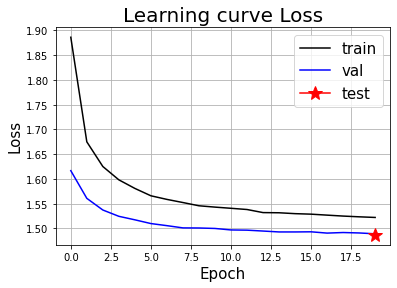

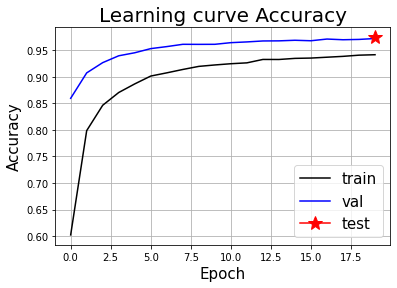

In [12]:
plot_learning_curves(loss, loss_test, 'Loss')
plot_learning_curves(acc, acc_test, 'Accuracy')